# DSCI 100 Group Project Report - Group 17

## Introduction

Introduction:
* provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
* clearly state the question you tried to answer with your project
* identify and describe the dataset that was used to answer the question



Auditing firms have a very important responsibility in catching fraud cases. Firms performing audits must carefully examine the financial records of businesses to ensure that they are following accounting laws. To properly perform audits, auditors must go through financial records such as receipts, balance sheets, etc. This is a lot of data to analyze. The question we want to answer is: can fruadulent firms can be correctly predicted using risk factors from the dataset and a k-nearest neighbours approach?

The dataset being used will show annual audit data from 777 firms across 14 different sectors. There are 17 columns of observations in the dataset, the risk class column shows whether the case is fraudulent or not. 

### Variable Information

**Note:** no units were provided for variables

| | Inherent Risk Factors | | Control Risk Factors |
| --- | --- | ---| --- |
| ParaA | Discrepancy in planned-expenditure of inspection and summary report A in Rs | Sector score | Historical risk score value of the target-unit |
| ParaB | Discrepancy in unplanned-expenditure of inspection and summary report B in Rs | Loss | Amount of loss suffered by the firm last year. |
| Total | Total amount of discrepancy found in other reports Rs | History | Average historical loss suffered by firm in the last 10 years. |
| Number | Historical discrepancy score. | District score | Historical risk score of a district in the last 10 years. |
| Money Value | Amount of money involved in misstatements in the past audits. | | |
| Sector ID | Unique ID of the target sector. | Location ID | Unique ID of the city/province. |
| ARS | Total risk score using analytical procedure. | Audit ID | Unique Id assigned to an audit case. |
| Risk class | Risk Class assigned to an audit-case, 1=fraud or 0=no fraud (Target Feature) 

## Methods and Results

Methods & Results:
* describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis. 
* Your report should include code which:
    * loads data from the original source on the web
    * wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
    * performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
    * creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
    * performs the data analysis
    * creates a visualization of the analysis 
    * note: all tables and figure should have a figure/table number and a legend



In [1]:
# open packages
library(tidyverse)
library(tidymodels)
library(readr)
library(dplyr)
library(ggplot2)
library(gridExtra)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
# import the data set, make column names consistent
url <- "https://raw.githubusercontent.com/hakkd/dsci-100-project-group17/main/trial.csv"

column_names = c("sector_score", "location_id", "para_a", "score_a", "para_b", "score_b", 
             "total", "numbers", "marks", "money_value", "money_marks", "district", "loss", 
             "loss_score", "history", "history_score", "score", "risk")

audit_data <- read_csv(url, col_names = column_names, skip = 1)

# dropping location_id column (not useful)
audit_data <- select(audit_data, -location_id)

head(audit_data)

Rows: 776 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): location_id
dbl (17): sector_score, para_a, score_a, para_b, score_b, total, numbers, ma...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


sector_score,para_a,score_a,para_b,score_b,total,numbers,marks,money_value,money_marks,district,loss,loss_score,history,history_score,score,risk
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.89,4.18,6,2.50,2,6.68,5,2,3.38,2,2,0,2,0,2,2.4,1
3.89,0.00,2,4.83,2,4.83,5,2,0.94,2,2,0,2,0,2,2.0,0
3.89,0.51,2,0.23,2,0.74,5,2,0.00,2,2,0,2,0,2,2.0,0
3.89,0.00,2,10.80,6,10.80,6,6,11.75,6,2,0,2,0,2,4.4,1
3.89,0.00,2,0.08,2,0.08,5,2,0.00,2,2,0,2,0,2,2.0,0
3.89,0.00,2,0.83,2,0.83,5,2,2.95,2,2,0,2,0,2,2.0,0


In [3]:
# change Risk to factor and recode as F (fraud) or N (no fraud)
audit_data <- audit_data |>
        mutate(risk = as.factor(risk))

audit_data$risk <- ifelse(audit_data$risk == "1", "F", "N")

# check that output is correct
head(audit_data)

sector_score,para_a,score_a,para_b,score_b,total,numbers,marks,money_value,money_marks,district,loss,loss_score,history,history_score,score,risk
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
3.89,4.18,6,2.50,2,6.68,5,2,3.38,2,2,0,2,0,2,2.4,F
3.89,0.00,2,4.83,2,4.83,5,2,0.94,2,2,0,2,0,2,2.0,N
3.89,0.51,2,0.23,2,0.74,5,2,0.00,2,2,0,2,0,2,2.0,N
3.89,0.00,2,10.80,6,10.80,6,6,11.75,6,2,0,2,0,2,4.4,F
3.89,0.00,2,0.08,2,0.08,5,2,0.00,2,2,0,2,0,2,2.0,N
3.89,0.00,2,0.83,2,0.83,5,2,2.95,2,2,0,2,0,2,2.0,N


In [4]:
set.seed(999) #set seed

# creating training and testing datasets
audit_split <- initial_split(audit_data, prop = 0.75, strata = risk)

audit_train <- training(audit_split)
audit_test <- testing(audit_split)

In [5]:
# check proportion of fraudulent and not fraudulent cases
audit_proportions <- audit_train |>
                      group_by(risk) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(audit_train))

audit_proportions

risk,n,percent
<chr>,<int>,<dbl>
F,364,62.6506
N,217,37.3494


Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


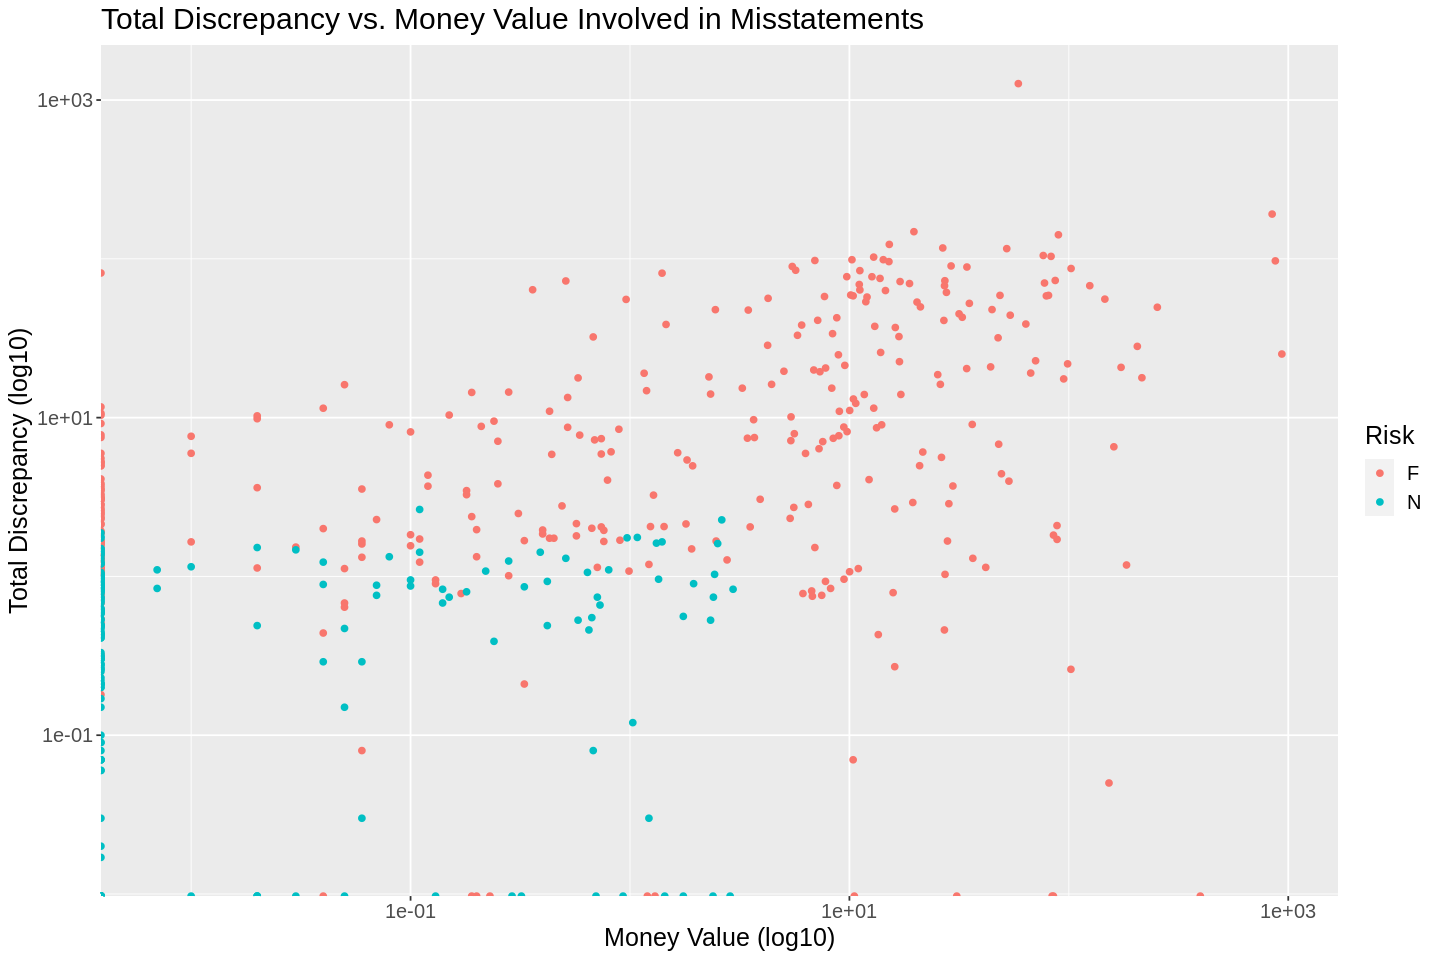

In [7]:
# visualize the distributions of continuous variables
options(repr.plot.width = 12, repr.plot.height = 8)

# make a scatter plot to compare the two variables of interest
audit_scatter <- audit_train |>
        ggplot(aes(x = money_value, y = total, colour = risk, fill = risk)) +
        geom_point() +
        scale_x_continuous(trans = "log10")+
        scale_y_continuous(trans = "log10") +
        labs(fill = "Risk", 
             colour = "Risk", 
             x = "Money Value (log10)", 
             y = "Total Discrepancy (log10)") +
        ggtitle("Total Discrepancy vs. Money Value Involved in Misstatements") +
        theme(text = element_text(size = 15))

audit_scatter

## Discussion

Discussion:

* summarize what you found
* discuss whether this is what you expected to find?
* discuss what impact could such findings have?
* discuss what future questions could this lead to?



## References

References:

* At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references)
* Make sure to cite the source of your data as well.



Hooda, Nishtha & Bawa, Seema & Rana, Prashant. (2018). Fraudulent Firm Classification: A Case Study of an External Audit. Applied Artificial Intelligence. 32. 10.1080/08839514.2018.1451032. 